# Hace tu visualizacion!
> Después del último post varias personas se acercaron con ideas para probar...

- toc: false 
- badges: true
- comments: false
- categories: [tutorial]
- image: images/evolucion-por-pais-con-guidelines.png

... asi que aqui vamos!

Para los posts anteriores utilicé los **datos** de la universidad de [Johns Hopkins](https://github.com/CSSEGISandData/COVID-19) y los [datos publicados nacionales](https://www.argentina.gob.ar/coronavirus/informe-diario), que a diferencia de los de Johns Hopkins, está abierta por provincias

Los datos abiertos por provincias provienen de un **scrapper que la saca de los PDFs**. Los primeros informes no seguian un patron tan sencillo para extraer, y luego estandarizaron en una enumeracion. Como los casos de los primeros informes eran unos pocos, el scrapper los desestima.

En este post, intencionalmente **no oculté las celdas**. 

En las notebooks de otros oculté el código por una cuestion de legibilidad. Si entran en [este](https://github.com/elsonidoq/covid-19-argentina/blob/master/_notebooks/2020-03-24-visualizando-los-datos-del-informe-diario.ipynb), van a ver dice `#hide` en muchas cells. Eso hace que se oculte al hacer el post

Para ver la documentación sobre como colaborar, pueden ir a [fastpages](https://fastpages.fast.ai/).


In [21]:
# voy a usar tanto matplotlib, altair y seaborn... porque se puede!
%matplotlib inline
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns
import pandas as pd

# Estos files estan en el repo
import arg_data
import global_data

## Cargamos los dataframes

In [6]:
# Baja los PDFs, los guarda en la carpeta cache y los lee
arg_df = arg_data.get_arg_df()

# Accede a la data de JH
global_df = global_data.get_global_covid_df()

In [7]:
arg_df.head()

,place,infered_place,infered_place_score,infected,date
72,Ciudad de Buenos Aires,Ciudad autonoma de Buenos Aires,1.000000,2,2020-03-13
71,Buenos Aires y,Provincia de Buenos Aires,1.000000,1,2020-03-13
69,Chaco y uno,Chaco,0.454545,3,2020-03-16
68,Ciudad Autónoma de Buenos Aires,Ciudad autonoma de Buenos Aires,1.000000,5,2020-03-16
70,Provincia de Buenos Aires,Provincia de Buenos Aires,1.000000,1,2020-03-16


In [8]:
global_df.head()

,date,country,confirmed,recovered,death,confirmed_growth_rate,death_growth_rate,first_infaction_date,days_from_first_infection,first_death_date,days_from_first_death
0,2020-01-22,Afghanistan,0,0.0,0,1.6,1.6,2020-02-24,-33,2020-03-22,-60
1,2020-01-23,Afghanistan,0,0.0,0,1.6,1.6,2020-02-24,-32,2020-03-22,-59
2,2020-01-24,Afghanistan,0,0.0,0,1.6,1.6,2020-02-24,-31,2020-03-22,-58
3,2020-01-25,Afghanistan,0,0.0,0,1.6,1.6,2020-02-24,-30,2020-03-22,-57
4,2020-01-26,Afghanistan,0,0.0,0,1.6,1.6,2020-02-24,-29,2020-03-22,-56


----
### A partir de aca, podes hacer cualquier estadística que combine estos datos

Por ejemplo, evolución (interactiva!) de los paises con mas infectados

In [22]:
total_confirmed_by_country = global_df.groupby('country').confirmed.max()
selected_countries = total_confirmed_by_country.sort_values(ascending=False)[total_confirmed_by_country > 1000].index

selection = alt.selection_multi(
    fields=['country'], bind='legend', init=[{'country': c} for c in selected_countries[:10]]
)


(
    alt.Chart(global_df[(global_df.confirmed > 0) & (global_df.country.isin(selected_countries))])
       .mark_line()
       .encode(
           x='days_from_first_infection', 
           y=alt.Y('confirmed', scale=alt.Scale(type='log')), 
           color='country',
           opacity=alt.condition(selection, alt.value(.8), alt.value(.05))
       ).add_selection(selection)
        .properties(width=650, height=400)
       
)

alt.Chart(...)

_Y si no te llevas bien con altair (como yo!), podes usar el good 'ol matplotlib_

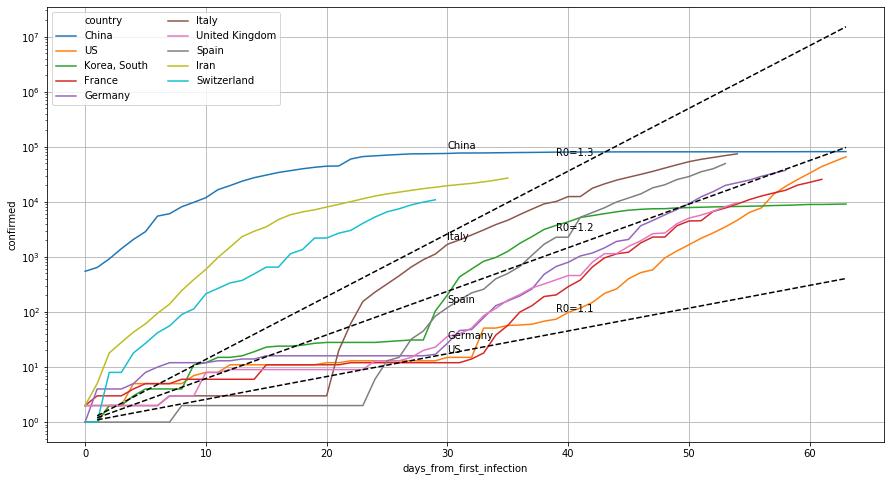

In [23]:
import numpy as np

fig = plt.figure(figsize=(15,8))
ax = fig.subplots()
plot_df = global_df[(global_df.confirmed > 0) & (global_df.country.isin(selected_countries[:10]))].sort_values('date')

sns.lineplot(
    data=plot_df, 
    x='days_from_first_infection', 
    y='confirmed', 
    hue='country',
)

for country in selected_countries[:5]:
    cdf = plot_df[plot_df.country == country]
    loc = min(30, len(cdf)-1)
    row = cdf.iloc[loc]
    plt.text(row.days_from_first_infection, row.confirmed * 1.2, country)

x=np.linspace(1, global_df.days_from_first_infection.max())
def plot_rate(rate):
    y = rate ** x
    ax.semilogy(x, y, 'k--')
    plt.text(x[30], y[30] * 2.5, f'R0={rate}')
    

plot_rate(1.1)
plot_rate(1.2)
plot_rate(1.3)
ax.grid()
plt.legend(loc='best', ncol=2);

In [20]:
# guarda la imagen para usarla en el post

fig.savefig('../images/evolucion-por-pais-con-guidelines.png')